In [1]:
import os
import cca_core
from time import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import CKA
import torchCKA
import gc
import time
from tqdm import tqdm
from IPython.core.debugger import set_trace

In [ ]:
def save_means(means, meansname):

    with open(meansname, 'wb') as handle:
        pickle.dump(means, handle, protocol=pickle.HIGHEST_PROTOCOL)


_DIR = "dir/with/activations/"
_MODEL_A = "model name you want to test"
_MODEL_B = "model name you want to test"
_LAYER_A = 0 # layer number of model A you want to test
_LAYER_B = 0 # layer number of model B you want to test

In [2]:
files = [x for x in os.listdir(_DIR) if x.startswith(f"{_MODEL_A}-attention-{_LAYER_A}-") or x.startswith(f"{_MODEL_B}-attention-{_LAYER_B}-49")]
      
diz = {}
con = 20 
mincon = 20
_batch = 3100

for x in files:
    _epoch = int(x.split("-")[3])
    if "attention" in x.split("-")[1] and _epoch <= con and _epoch >= con-mincon and int(x.split("-")[4][:-2]) < _batch or x.split("-")[0] == "LMGigo" and _epoch == 49 and int(x.split("-")[4][:-2]) < _batch: #and _epoch >= con-10:
        try:
            diz[x] = x
            diz[x] = pickle.load(open(f"{_DIR}{x}", "rb"))
        except Exception as e:
            print(e)
            continue


5383


In [3]:
print(diz.keys())


dict_keys(['POS2-attention-0-1-416.p', 'POS2-attention-0-1-448.p', 'POS2-attention-0-1-480.p', 'POS2-attention-0-1-512.p', 'POS2-attention-0-1-544.p', 'POS2-attention-0-1-576.p', 'POS2-attention-0-1-608.p', 'POS2-attention-0-1-64.p', 'POS2-attention-0-1-640.p', 'POS2-attention-0-1-672.p', 'POS2-attention-0-1-704.p', 'POS2-attention-0-1-736.p', 'POS2-attention-0-1-768.p', 'POS2-attention-0-1-800.p', 'POS2-attention-0-1-864.p', 'POS2-attention-0-1-896.p', 'POS2-attention-0-1-928.p', 'POS2-attention-0-1-96.p', 'POS2-attention-0-1-960.p', 'POS2-attention-0-1-992.p', 'POS2-attention-0-10-0.p', 'POS2-attention-0-10-1024.p', 'POS2-attention-0-10-1056.p', 'POS2-attention-0-10-1088.p', 'POS2-attention-0-10-1120.p', 'POS2-attention-0-10-1152.p', 'POS2-attention-0-10-1184.p', 'POS2-attention-0-10-1216.p', 'POS2-attention-0-1-1280.p', 'POS2-attention-0-1-1312.p', 'POS2-attention-0-1-1344.p', 'POS2-attention-0-1-1376.p', 'POS2-attention-0-1-1408.p', 'POS2-attention-0-1-1440.p', 'POS2-attention-0-1-

In [4]:
kys = set()
for x in diz.keys():
    x = x.split("-")[3]
    if x not in kys:
        kys.add(int(x))
print(sorted(kys))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 49]
21


In [5]:
def get_svcca(n, model):
    epoch1 = [diz[x] for x in diz.keys() if x.split("-")[3] == f"{n}" and x.split("-")[0] == model]#and diz[x].shape[0] == 32]
    new = np.concatenate(epoch1, axis=0)

    newnew = new.reshape((new.shape[0], new.shape[1]*new.shape[2]))

    return newnew

In [6]:
gc.collect()
kys = list(sorted(kys))
limit = len(kys)
forsvcca1 = [0] * (len(kys))
forsvcca2 = [0]
for x in range(0, limit):
    print(x)
    if x < limit-1:
        forsvcca1[x] = get_svcca(kys[x], _MODEL_A)
    else:
        forsvcca1[x] = get_svcca(kys[x], _MODEL_B)
        
    forsvcca2[0] = get_svcca(kys[-1], _MODEL_B)

diz = 0
gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


0

100%|██████████| 20/20 [25:02<00:00, 75.10s/it]


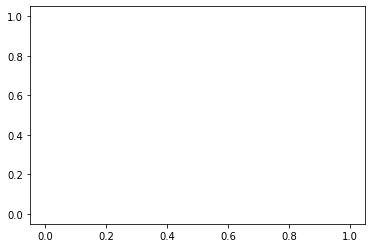

In [8]:
from time import time
gc.collect()
meanslinear = []
meanskernel = []
meanskernel5 = []
meanssvcca = []
for x in tqdm(range(len(forsvcca1[:-1]))):

    meanskernel.append(torchCKA.cka(torchCKA.gram_rbf(forsvcca1[x]), torchCKA.gram_rbf(forsvcca2[0])))
    meanskernel5.append(torchCKA.cka(torchCKA.gram_rbf(forsvcca1[x], .5), torchCKA.gram_rbf(forsvcca2[0], .5)))
    meanslinear.append(torchCKA.cka(torchCKA.gram_linear(forsvcca1[x]), torchCKA.gram_linear(forsvcca2[0])))
    
    meanssvcca.append(cca_core.get_cca_similarity(forsvcca1[x], forsvcca2[0], epsilon=1e-6, verbose = False)["mean"])

plt.plot(range(len(meanskernel[:])), meanskernel[:])

1


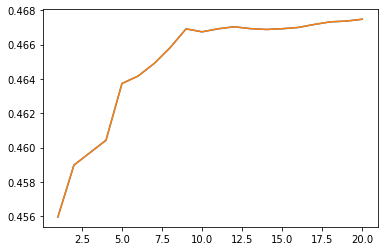

In [9]:
plt.plot(kys[:-1], meanssvcca[:])
print(len(forsvcca2))

In [10]:
save_means(meanskernel[:], "meansPOS_vs_finalLM_kernellayer1-POS41-49.p")
save_means(meanslinear[:], "meansPOS_vs_finalLM_linearlayer1-POS41-49.p")
save_means(meanskernel5[:], "meansPOS_vs_finalLM_kernel5layer1-5POS41-49.p")
save_means(meanssvcca[:], "meansPOS_vs_finalLM_svccalayer0-POS0-20.p")

In [11]:
means1 = pickle.load(open("meansPOS_vs_finalLM_kernel5layer1-5POS0-20.p","rb"))
means2 = pickle.load(open("meansPOS_vs_finalLM_kernel5layer1-5POS21-40.p","rb"))
means3 = pickle.load(open("meansPOS_vs_finalLM_kernel5layer1-5POS41-49.p","rb"))

l1means = means1 + means2 + means3

means1 = pickle.load(open("meansPOS_vs_finalLM_linearlayer1-POS0-20.p","rb"))
means2 = pickle.load(open("meansPOS_vs_finalLM_linearlayer1-POS21-40.p","rb"))
means3 = pickle.load(open("meansPOS_vs_finalLM_linearlayer1-POS41-49.p","rb"))

l2means = means1 + means2 + means3

means1 = pickle.load(open("meansPOS_vs_finalLM_kernellayer1-POS0-20.p","rb"))
means2 = pickle.load(open("meansPOS_vs_finalLM_kernellayer1-POS21-40.p","rb"))
means3 = pickle.load(open("meansPOS_vs_finalLM_kernellayer1-POS41-49.p","rb"))

l3means = means1 + means2 + means3

means1 = pickle.load(open("meansPOS_vs_finalLM_svccalayer0-POS0-20.p","rb"))
means2 = pickle.load(open("meansPOS_vs_finalLM_svccalayer0-POS21-40.p","rb"))
means3 = pickle.load(open("meansPOS_vs_finalLM_svccalayer0-POS41-49.p","rb"))

l4means = means1 + means2 + means3
l4means = [x[0] for x in l4means]

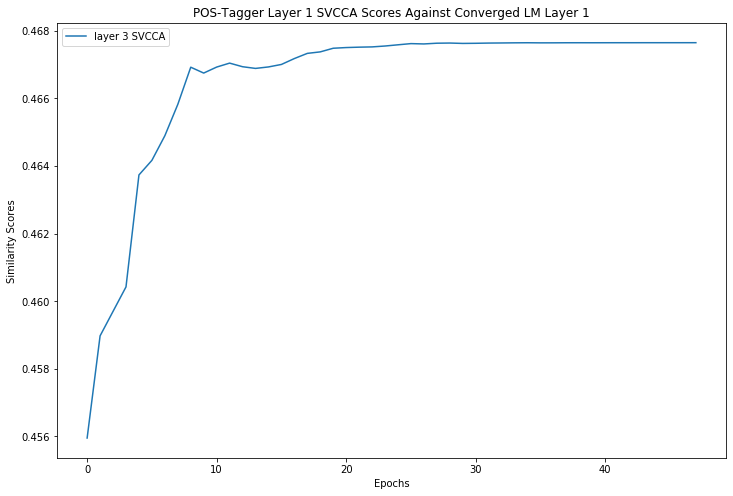

In [13]:
plt.figure(figsize=(12,8))
plt.plot(range(len(l4means)), l4means, label="layer 3 SVCCA")

plt.title("POS-Tagger Layer 1 SVCCA Scores Against Converged LM Layer 1")
plt.xlabel("Epochs")
plt.ylabel("Similarity Scores")

plt.legend()

In [26]:
means1 = pickle.load(open("meansPOS_vs_finalLM_kernel5layer1-5POS0-20.p","rb"))
means2 = pickle.load(open("meansPOS_vs_finalLM_kernel5layer1-5POS21-40.p","rb"))
means3 = pickle.load(open("meansPOS_vs_finalLM_kernel5layer1-5POS41-49.p","rb"))

l1means = means1 + means2 + means3

means1 = pickle.load(open("meansPOS_vs_finalLM_linearlayer1-POS0-20.p","rb"))
means2 = pickle.load(open("meansPOS_vs_finalLM_linearlayer1-POS21-40.p","rb"))
means3 = pickle.load(open("meansPOS_vs_finalLM_linearlayer1-POS41-49.p","rb"))

l2means = means1 + means2 + means3

means1 = pickle.load(open("meansPOS_vs_finalLM_kernellayer1-POS0-20.p","rb"))
means2 = pickle.load(open("meansPOS_vs_finalLM_kernellayer1-POS21-40.p","rb"))
means3 = pickle.load(open("meansPOS_vs_finalLM_kernellayer1-POS41-49.p","rb"))

l3means = means1 + means2 + means3


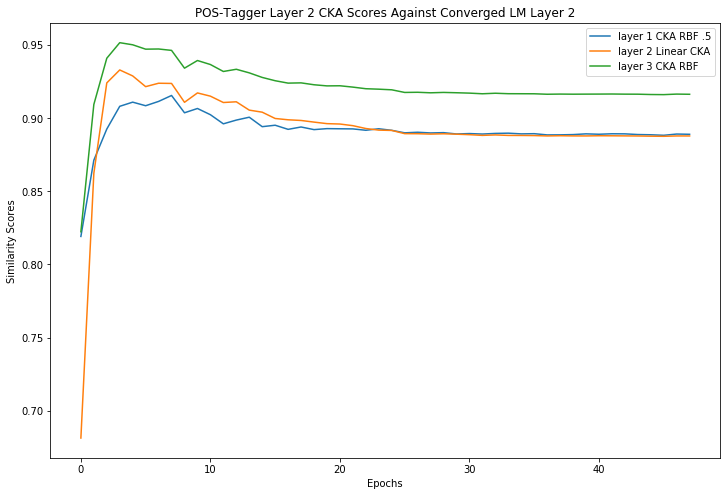

In [27]:
plt.figure(figsize=(12,8))
plt.plot(range(len(l1means)), l1means, label="layer 1 CKA RBF .5")
plt.plot(range(len(l2means)), l2means, label="layer 2 Linear CKA")
plt.plot(range(len(l3means)), l3means, label="layer 3 CKA RBF")
plt.title("POS-Tagger Layer 2 CKA Scores Against Converged LM Layer 2")
plt.xlabel("Epochs")
plt.ylabel("Similarity Scores")

plt.legend()

In [12]:
import pickle

means1 = pickle.load( open( "meansprogresskernelLM0-10.p", "rb" ) )
means2 = pickle.load( open( "meansprogresskernelLM11-20.p", "rb" ) )
means3 = pickle.load( open( "meansprogresskernelLM21-30.p", "rb" ) )
means4 = pickle.load( open( "meansprogresskernelLM31-40.p", "rb" ) )
means5 = pickle.load( open( "meansprogresskernelLM41-49.p", "rb" ) )

means6 = pickle.load( open( "meansprogresslinearLM0-10.p", "rb" ) )
means7 = pickle.load( open( "meansprogresslinearLM11-20.p", "rb" ) )
means8 = pickle.load( open( "meansprogresslinearLM21-30.p", "rb" ) )
means9 = pickle.load( open( "meansprogresslinearLM31-40.p", "rb" ) )
means10 = pickle.load( open( "meansprogresslinearLM41-49.p", "rb" ) )

means11 = pickle.load( open( "meansprogresssvccaLM0-10.p", "rb" ) )
means12 = pickle.load( open( "meansprogresssvccaLM11-20.p", "rb" ) )
means13 = pickle.load( open( "meansprogresssvccaLM21-30.p", "rb" ) )
means14 = pickle.load( open( "meansprogresssvccaLM31-40.p", "rb" ) )
means15 = pickle.load( open( "meansprogresssvccaLM41-49.p", "rb" ) )

means16 = pickle.load( open( "meansprogresskernel5LM0-10.p", "rb" ) )
means17 = pickle.load( open( "meansprogresskernel5LM11-20.p", "rb" ) )
means18 = pickle.load( open( "meansprogresskernel5LM21-30.p", "rb" ) )
means19 = pickle.load( open( "meansprogresskernel5LM31-40.p", "rb" ) )
means20 = pickle.load( open( "meansprogresskernel5LM41-49.p", "rb" ) )



In [ ]:
allmeans3 = [x[0] for x in allmeans3]

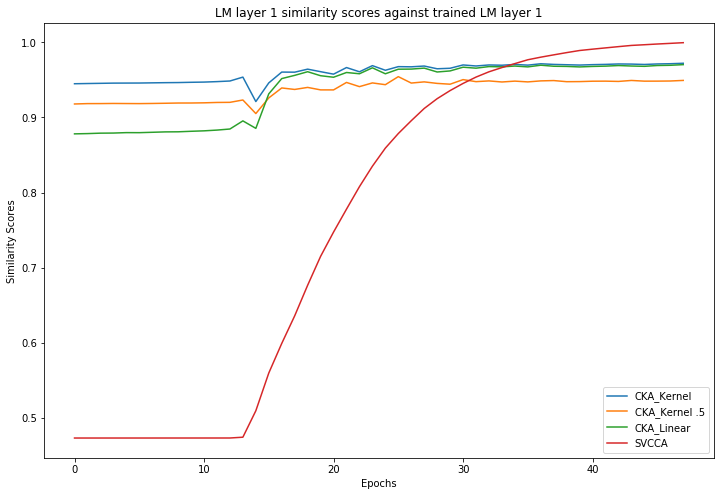

In [16]:
allmeans1 = means1+means2+means3+means4+means5
allmeans2 = means6+means7+means8+means9+means10
allmeans3 = means11+means12+means13+means14+means15
allmeans3 = [x[0] for x in allmeans3]
allmeans4 = means16+means17+means18+means19+means20

plt.figure(figsize=(12,8))
plt.plot(range(len(allmeans1)),allmeans1, label="CKA_Kernel")
plt.plot(range(len(allmeans4)),allmeans4, label="CKA_Kernel .5")
plt.plot(range(len(allmeans2)),allmeans2, label="CKA_Linear")
plt.plot(range(len(allmeans3)),allmeans3, label="SVCCA")

plt.title("LM layer 1 similarity scores against trained LM layer 1")
plt.xlabel("Epochs")
plt.ylabel("Similarity Scores")
plt.legend()

In [2]:

files = [x for x in os.listdir(_DIR) if x.startswith(_MODEL_A)]
print(len(files))
      
diz = {}

_batch = 3100

for x in files:
    _epoch = int(x.split("-")[3])
    if "attention" in x.split("-")[1] and _epoch == 49 and int(x.split("-")[4][:-2]) < _batch:
        try:
            diz[x] = x
            diz[x] = pickle.load(open(f"{_DIR}{x}", "rb"))
            #print(diz[x])
        except Exception as e:
            print(e)
            continue


39270


In [3]:
diz.keys()

dict_keys(['LMGigo-attention-2-49-1152.p', 'LMGigo-attention-2-49-160.p', 'LMGigo-attention-2-49-2016.p', 'LMGigo-attention-2-49-2464.p', 'LMGigo-attention-2-49-32.p', 'LMGigo-attention-2-49-736.p', 'LMGigo-attention-3-49-1152.p', 'LMGigo-attention-3-49-160.p', 'LMGigo-attention-3-49-2016.p', 'LMGigo-attention-3-49-2464.p', 'LMGigo-attention-3-49-32.p', 'LMGigo-attention-3-49-736.p', 'LMGigo-attention-4-49-1216.p', 'LMGigo-attention-4-49-1632.p', 'LMGigo-attention-4-49-2080.p', 'LMGigo-attention-4-49-2528.p', 'LMGigo-attention-4-49-32.p', 'LMGigo-attention-4-49-736.p', 'LMGigo-attention-2-49-0.p', 'LMGigo-attention-2-49-1024.p', 'LMGigo-attention-2-49-1056.p', 'LMGigo-attention-2-49-1088.p', 'LMGigo-attention-2-49-1120.p', 'LMGigo-attention-3-49-0.p', 'LMGigo-attention-3-49-1024.p', 'LMGigo-attention-3-49-1056.p', 'LMGigo-attention-3-49-1088.p', 'LMGigo-attention-3-49-1120.p', 'LMGigo-attention-5-49-0.p', 'LMGigo-attention-5-49-1024.p', 'LMGigo-attention-5-49-1056.p', 'LMGigo-attention

In [4]:
def get_svcca(n, model):
    epoch1 = [diz[x] for x in diz.keys() if x.split("-")[2] == f"{n}" and x.split("-")[0] == model]#and diz[x].shape[0] == 32]
    new = np.concatenate(epoch1, axis=0)
    newnew = new.reshape((new.shape[0], new.shape[1]*new.shape[2]))

    return newnew

In [5]:
kys = set()
for x in diz.keys():
    x = x.split("-")[2]
    if x not in kys:
        kys.add(int(x))
print(sorted(kys))

[0, 1, 2, 3, 4, 5]
6


In [6]:
gc.collect()
kys = list(sorted(kys))
limit = len(kys)
forsvcca1 = [0] * (len(kys))

for x in range(0, limit):
    forsvcca1[x] = get_svcca(kys[x], MODELNAME)

diz = 0
gc.collect()

0
1
2
3
4
5


0

In [7]:
forsvcca1[0].shape

(3104, 15360)

In [ ]:
from time import time
gc.collect()
meanslinear = np.ones((len(forsvcca1),len(forsvcca1)))

meanskernel = np.ones((len(forsvcca1),len(forsvcca1)))

meanssvcca = np.ones((len(forsvcca1),len(forsvcca1)))



for x in tqdm(range(len(forsvcca1))):
    for y in tqdm(range(len(forsvcca1))):
                meanssvcca[x,y] = cca_core.get_cca_similarity(forsvcca1[y], forsvcca1[x], epsilon=1e-6, verbose = False)["mean"][0]


        #meanskernel[x,y] = torchCKA.cka(torchCKA.gram_rbf(forsvcca1[y]), torchCKA.gram_rbf(forsvcca1[x]))
        #meanslinear[x,y] = torchCKA.cka(torchCKA.gram_linear(forsvcca1[y]), torchCKA.gram_linear(forsvcca1[x]))

        #meanssvcca[x,y] = cca_core.get_cca_similarity(forsvcca1[x], forsvcca1[-1], epsilon=1e-6, verbose = False)["mean"][0]

#plt.plot(range(len(meanskernel[:-1])), meanskernel[:-1])

([<matplotlib.axis.YTick at 0x7fab272f0a90>,
 <a list of 6 Text yticklabel objects>)

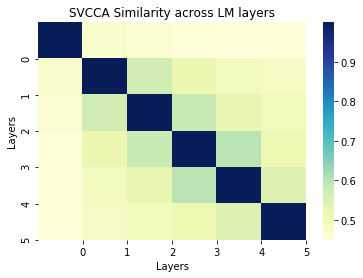

In [20]:
import seaborn as sns

sns.heatmap(meanssvcca,cmap="YlGnBu")
plt.title("SVCCA Similarity across LM layers")
plt.ylabel("Layers")
plt.xlabel("Layers")